##### 🔴 Scenario 3: Rare Churn (Churn < 5%)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    recall_score,
    ConfusionMatrixDisplay
)

# Plot style
sns.set_theme(style="whitegrid")


In [28]:
# load dataset with rare churn rate
df = pd.read_csv("../data/user_activity_rarechurn.csv")
df.head()


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
0,1,973,158,7,14.64,1,0,0
1,2,810,168,3,21.87,0,0,0
2,3,317,160,6,14.43,1,0,0
3,4,736,31,6,9.19,0,0,0
4,5,795,120,3,10.92,0,0,0


In [29]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            1000 non-null   int64  
 1   signup_days_ago        1000 non-null   int64  
 2   last_active_days_ago   1000 non-null   int64  
 3   num_logins_last_month  1000 non-null   int64  
 4   avg_session_length     1000 non-null   float64
 5   num_support_tickets    1000 non-null   int64  
 6   is_premium             1000 non-null   int64  
 7   churned                1000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 62.6 KB


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,511.802000,146.496000,4.907000,14.926360,0.48000,0.283000,0.051000
std,288.819436,281.747682,85.878502,2.167267,5.066808,0.68853,0.450682,0.220108
min,1.000000,30.000000,0.000000,0.000000,-1.320000,0.00000,0.000000,0.000000
25%,250.750000,268.500000,76.000000,3.000000,11.235000,0.00000,0.000000,0.000000
50%,500.500000,504.500000,142.500000,5.000000,14.845000,0.00000,0.000000,0.000000
75%,750.250000,759.750000,224.000000,6.000000,18.292500,1.00000,1.000000,0.000000
max,1000.000000,999.000000,299.000000,12.000000,31.910000,4.00000,1.000000,1.000000


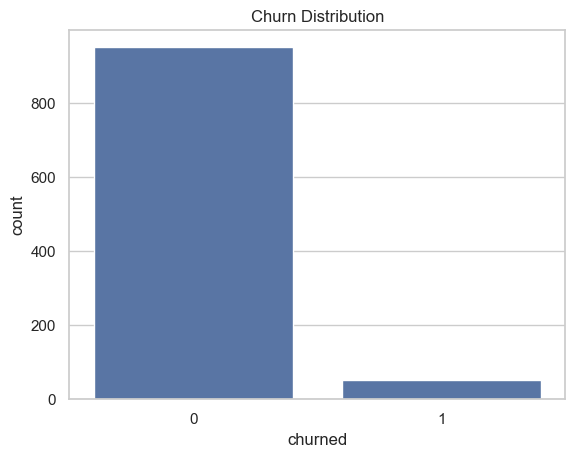

In [30]:
# Quick EDA

sns.countplot(x="churned", data=df)
plt.title("Churn Distribution")
plt.show()


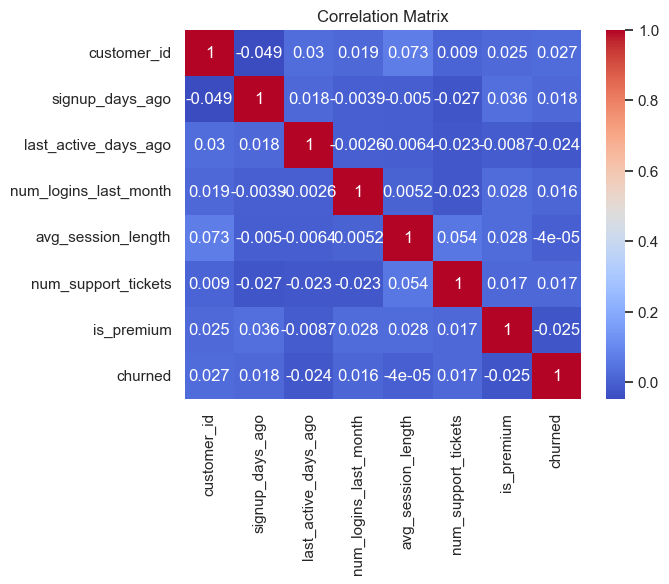

In [31]:
# check correlation

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [32]:
# feature prep

X = df.drop(columns=["customer_id", "churned"])
y = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


✅ Recommended Baseline Model:
* scale_pos_weight compensates for extreme imbalance.
* XGBoost handles imbalance very well and gives feature importances.
* SMOTE ensures training data is more balanced.

In [33]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = XGBClassifier(
    scale_pos_weight=(len(y_resampled) - sum(y_resampled)) / sum(y_resampled),
    # use_label_encoder=False, # This is deprecated in newer versions of XGBoost
    eval_metric='logloss',
    random_state=42
)
model.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Model Evaluation:

In [34]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       190
           1       0.00      0.00      0.00        10

    accuracy                           0.84       200
   macro avg       0.47      0.44      0.46       200
weighted avg       0.90      0.84      0.87       200

Confusion Matrix:
 [[169  21]
 [ 10   0]]
ROC AUC: 0.4510526315789473
PR AUC: 0.05143325993186447


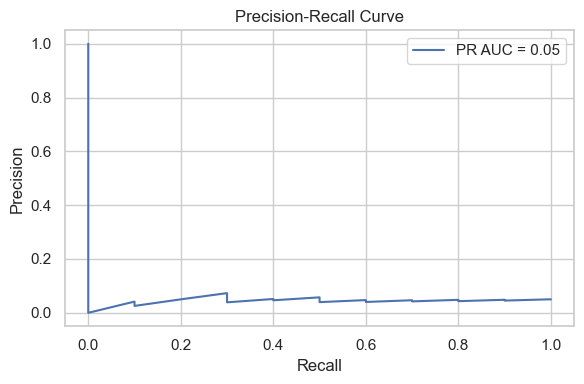

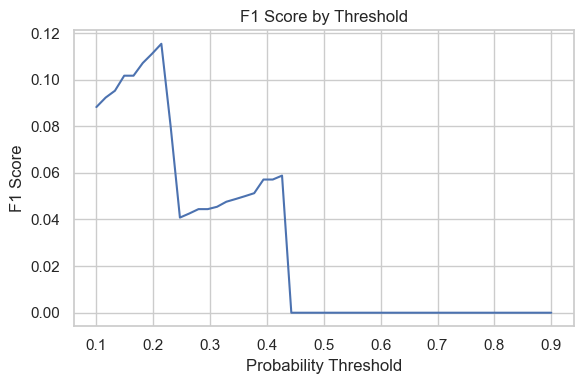

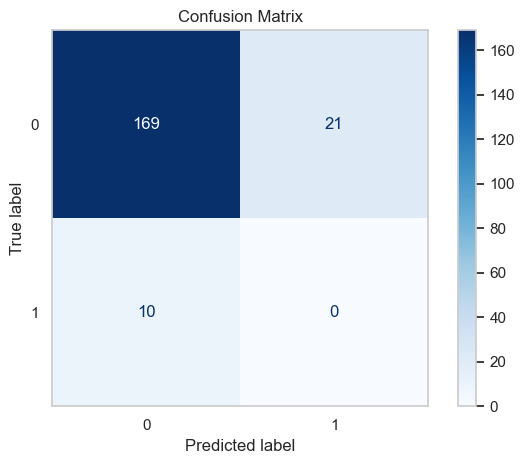

In [35]:
# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Threshold vs. F1 Score
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix (with default threshold)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


🔧 __Optional: Adjust Threshold__  
If you want to manually set a threshold to be more aggressive catching churners:

In [38]:
y_pred_custom = (y_proba >= 0.3).astype(int)  # Lower threshold

print("Recall (threshold 0.3):", recall_score(y_test, y_pred_custom))


Recall (threshold 0.3): 0.1


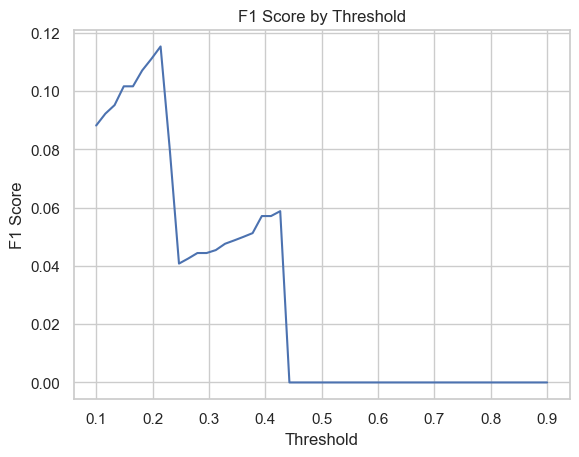

In [39]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()
